Import libraries

In [ ]:
import json
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading competition data

In [ ]:
train = pd.read_json('train.json', lines=True)
test = pd.read_json('test.json', lines=True)
sample_sub = pd.read_csv('sample_submission.csv')

Inspecting Elements

In [ ]:
print(train.columns)
print(train.shape)
if ~ train.isnull().values.any(): print('No missing values')
train.head()

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')
(2400, 19)
No missing values


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [ ]:
print (test.columns)
print(test.shape)
if ~ test.isnull().values.any(): print('No missing values')
test.head()

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'seq_length', 'seq_scored'],
      dtype='object')
(3634, 7)
No missing values


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [ ]:
print (sample_sub.columns)
print(sample_sub.shape)
if ~ sample_sub.isnull().values.any(): print('No missing values')
sample_sub.head()

Index(['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C',
       'deg_50C'],
      dtype='object')
(457953, 6)
No missing values


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


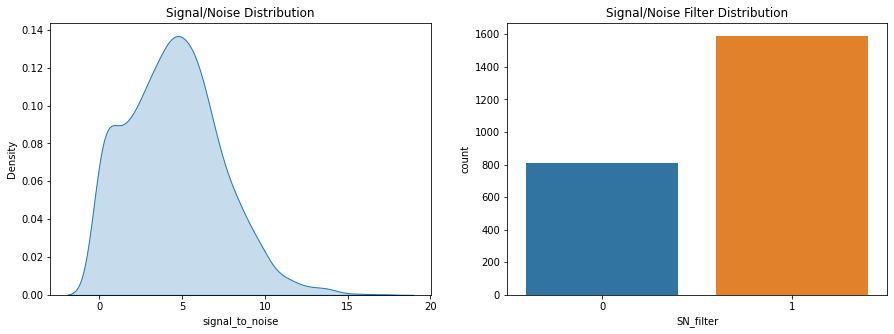

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.kdeplot(train['signal_to_noise'], shade = True, ax = ax[0])
sns.countplot(train['SN_filter'], ax = ax[1])

ax[0].set_title('Signal/Noise Distribution')
ax[1].set_title('Signal/Noise Filter Distribution');

Preprocessing

In [ ]:
#target columns
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

Tokenize RNA sequence

In [ ]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

In [ ]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

In [ ]:
train_filtered = train.loc[train.SN_filter == 1]
train_inputs = torch.tensor(preprocess_inputs(train_filtered)).to(device)
print("input shape: ", train_inputs.shape)
train_labels = torch.tensor(
    np.array(train_filtered[target_cols].values.tolist()).transpose(0, 2, 1)
).float().to(device)
print("output shape: ", train_labels.shape)

input shape:  torch.Size([1589, 107, 3])
output shape:  torch.Size([1589, 68, 5])


Model

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, 
                 hidden_layers=3):
      
        super(LSTM, self).__init__()
        
        self.pred_len = pred_len

        self.embeding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.rnn = nn.LSTM(
            input_size=embed_dim * 3,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True,
        )
               
        self.linear = nn.Linear(hidden_dim * 2, 5)
        
    
    def forward(self, seqs):
        embed = self.embeding(seqs)
        reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        output, hidden = self.rnn(reshaped)
        truncated = output[:, : self.pred_len, :]
        out = self.linear(truncated)
        return out

In [ ]:
mse_loss = nn.MSELoss()
def compute_loss(batch_X, batch_Y, model, optimizer=None, is_train=True):
    model.train(is_train)

    pred_Y = model(batch_X)

    loss = mse_loss(pred_Y, batch_Y)

    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

K-Fold

In [ ]:
#basic training configuration
FOLDS = 2
EPOCHS = 50
BATCH_SIZE = 64
VERBOSE = 2
LR = 0.01

In [ ]:
#get different test sets and process each
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = torch.tensor(preprocess_inputs(public_df)).to(device)
private_inputs = torch.tensor(preprocess_inputs(private_df)).to(device)

public_loader = DataLoader(TensorDataset(public_inputs), shuffle=False, batch_size=BATCH_SIZE)
private_loader = DataLoader(TensorDataset(private_inputs), shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
from sklearn.model_selection import KFold
lstm_histories = []
lstm_private_preds = np.zeros((private_df.shape[0], 130, 5))
lstm_public_preds = np.zeros((public_df.shape[0], 107, 5))

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

    model = LSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            train_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=True)
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            val_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=False)
            val_losses_batch.append(val_loss)
        train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
        val_losses.append(sum(val_losses_batch) / len(val_losses_batch))
    model_state = model.state_dict()
    del model
            
    lstm_histories.append({'train_loss': train_losses, 'val_loss': val_losses})


    lstm_short = LSTM(seq_len=107, pred_len=107).to(device)
    lstm_short.load_state_dict(model_state)
    lstm_short.eval()
    lstm_public_pred = np.ndarray((0, 107, 5))
    for batch in public_loader:
        batch_X = batch[0]
        pred = lstm_short(batch_X).detach().cpu().numpy()
        lstm_public_pred = np.concatenate([lstm_public_pred, pred], axis=0)
    lstm_public_preds += lstm_public_pred / FOLDS

    lstm_long = LSTM(seq_len=130, pred_len=130).to(device)
    lstm_long.load_state_dict(model_state)
    lstm_long.eval()
    lstm_private_pred = np.ndarray((0, 130, 5))
    for batch in private_loader:
        batch_X = batch[0]
        pred = lstm_long(batch_X).detach().cpu().numpy()
        lstm_private_pred = np.concatenate([lstm_private_pred, pred], axis=0)
    lstm_private_preds += lstm_private_pred / FOLDS
    
    del lstm_short, lstm_long

100%|██████████| 50/50 [17:32<00:00, 21.05s/it]


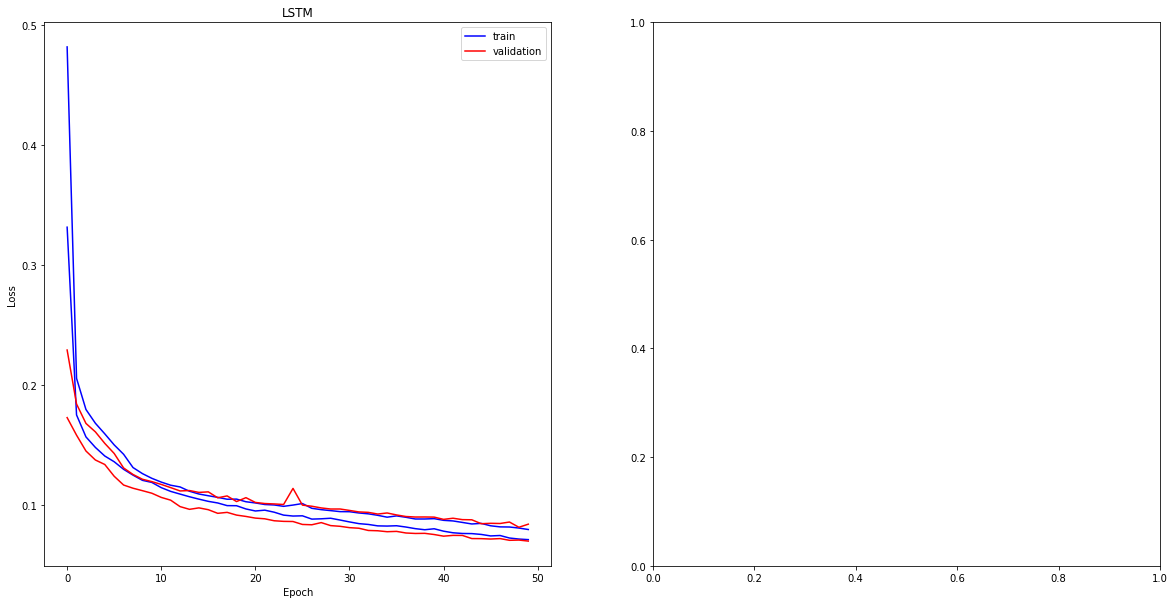

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
for history in lstm_histories:
    ax[0].plot(history['train_loss'], 'b')
    ax[0].plot(history['val_loss'], 'r')

ax[0].set_title('LSTM')


ax[0].legend(['train', 'validation'], loc = 'upper right')

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch');

Submission

In [ ]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)

In [ ]:
preds_lstm = []

for df, preds in [(public_df, lstm_public_preds), (private_df, lstm_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm.append(single_df)

preds_lstm_df = pd.concat(preds_lstm)
preds_lstm_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.834826,0.687203,2.083668,0.583259,0.754933,id_00073f8be_0
1,2.709341,3.959845,5.009376,3.786767,3.160927,id_00073f8be_1
2,1.321399,0.562742,0.740488,0.800006,0.770328,id_00073f8be_2
3,1.404334,1.188590,1.247695,1.555338,1.390971,id_00073f8be_3
4,1.013102,0.744308,0.822424,0.955020,0.919603,id_00073f8be_4


In [ ]:
submission = sample_sub[['id_seqpos']].merge(preds_lstm_df, on=['id_seqpos'])

#sanity check
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.834826,0.687203,2.083668,0.583259,0.754933
1,id_00073f8be_1,2.709341,3.959845,5.009376,3.786767,3.160927
2,id_00073f8be_2,1.321399,0.562742,0.740488,0.800006,0.770328
3,id_00073f8be_3,1.404334,1.188590,1.247695,1.555338,1.390971
4,id_00073f8be_4,1.013102,0.744308,0.822424,0.955020,0.919603


In [ ]:
submission.to_csv('submission.csv', index=False)
print('Submission saved')

Submission saved
